In [3]:
%load_ext autoreload
%autoreload 2
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.features.games import GameFeatures
from src.utils import load_data_template

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
data = load_data_template(season=False)
data.dropna(subset=['a_win'], inplace=True)
print(data.shape)
data.sample()

(2117, 7)


,Season,team_a,team_b,in_target,game_set,a_win,DayNum
3974,2011,1266,1393,False,0,True,139


## Neural net

### Tensorflow nn

In [10]:
%load_ext autoreload
%autoreload 2
from src.features import GameFeatures, GameDetailedFeatures, SeedFeatures
from src.utils import load_data_template
from src.models.nn.ann import ANN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
print('Running Feature Pipeline')

print('-- Seeds --')
seed_feat = SeedFeatures()
data = seed_feat.per_team_wrapper(
    data, seed_feat.team_seeds,
    per_game=False, per_day=False)
print(data.shape)

print('-- Game Features --')
game_feat = GameFeatures()
data = game_feat.per_team_wrapper(
    data, game_feat.last_games_won_in_season)
data = game_feat.per_team_wrapper(
    data, game_feat.last_games_won_in_tourney)
data = game_feat.per_team_wrapper(
    data, game_feat.last_games_won_against_opponent,
    per_game=True)
data = game_feat.per_team_wrapper(
    data, game_feat.games_won_in_tourney_against_opponent,
    per_game=True)
data.fillna(0, inplace=True)
print(data.shape)
print('-- Game Detailed Features --')
game_detail_feat = GameDetailedFeatures(default_lags=7)
data = game_detail_feat.per_team_wrapper(
    data, game_detail_feat.detail_features_by_game,
    per_day=True)
data.fillna(0, inplace=True)
print(data.shape)

data.sample()

Running Feature Pipeline
-- Seeds --
(159802, 37)
-- Game Features --
(159802, 63)
-- Game Detailed Features --
(159802, 245)


,Season,team_a,team_b,in_target,game_set,a_win,DayNum,seed_team_a_x,seed_team_b_x,last_games_won_in_season_team_a_x,...,Stl_team_b_lag-5,Stl_team_b_lag-6,Stl_team_b_lag-7,TO_team_b_lag-1,TO_team_b_lag-2,TO_team_b_lag-3,TO_team_b_lag-4,TO_team_b_lag-5,TO_team_b_lag-6,TO_team_b_lag-7
80229,2003,1159,1331,False,1,False,61,0.0,0.0,12.0,...,2.0,11.0,4.0,11.0,12.0,13.0,15.0,13.0,15.0,11.0


In [12]:
print(data.shape)
print(data.dropna().shape)

(159802, 245)
(159802, 245)


In [13]:
X = data.loc[~data.in_target].drop(['Season', 'a_win', 'in_target', 'team_a', 'team_b', 'DayNum'], axis=1)
Y = data.loc[~data.in_target, 'a_win']*1
X_eval = data.loc[data.in_target].drop(['Season', 'a_win', 'in_target', 'team_a', 'team_b', 'DayNum'], axis=1)
Y_eval = data.loc[data.in_target, 'a_win']*1
X_eval, Y_eval = X_eval[~Y_eval.isnull()], Y_eval[~Y_eval.isnull()]

In [14]:
print(X_eval.shape)
print(X.shape)

(2565, 239)
(157237, 239)


In [16]:
sum(Y)/len(Y)

0.489445868338877

In [17]:
sum(Y_eval)/len(Y_eval)

0.05263157894736842

In [29]:
param_dict = {
    'input_dim': X.shape[1],
    'batch_size': 50,
    'hidden_units': [32],
    'eta': 0.01,
    'num_epochs': 10,
    'dropout': 0.2
}
print(param_dict)

{'input_dim': 239, 'batch_size': 50, 'hidden_units': [32], 'eta': 0.01, 'num_epochs': 10, 'dropout': 0.2}


In [30]:
ann = ANN(**param_dict)

In [28]:
ann.fit(X, Y, X_eval, Y_eval, verbose=True)

[ 1.  1.  1.  1.  1.]
[ 1.   0.5  0.5  0.5  0.5]
Epoch: 000 train_loss=3.766 eval_loss=12.277 --- time per epoch=7.02 seconds
[ 0.   0.   0.   0.   0.5]
[ 0.   0.5  0.   0.   0. ]
Epoch: 005 train_loss=3.570 eval_loss=0.861 --- time per epoch=6.02 seconds


([9.1370373,
  6.8666406,
  6.5581417,
  7.8891783,
  6.5720043,
  6.5442786,
  8.1560888,
  7.2444544,
  5.6742334,
  5.8995543,
  6.8805041,
  8.7730856,
  7.5668163,
  5.3102827,
  7.2721796,
  7.2444544,
  7.5252271,
  7.4836388,
  7.5668163,
  5.9550066,
  6.3050938,
  7.847589,
  5.941144,
  8.1699514,
  6.9082294,
  4.35706,
  7.4836388,
  6.3189573,
  6.9636812,
  7.847589,
  8.2254028,
  7.8753147,
  6.6274567,
  6.2219167,
  7.2583175,
  5.3102832,
  6.5442786,
  6.2635059,
  7.4836388,
  6.2635059,
  8.506176,
  6.3050938,
  8.2254028,
  4.946332,
  4.9324694,
  7.175139,
  7.8753147,
  5.3241453,
  5.604919,
  5.871829,
  6.5442786,
  5.6465077,
  10.468074,
  3.0814753,
  7.594542,
  5.3241453,
  8.1838131,
  5.1993794,
  7.5529528,
  6.2496424,
  7.6084046,
  4.9324689,
  4.0069718,
  5.9272804,
  6.0659099,
  2.3812997,
  8.4507246,
  6.6690454,
  7.511364,
  5.2964196,
  8.8424006,
  4.35706,
  3.9931092,
  6.2496428,
  6.5720043,
  6.2635055,
  6.3189573,
  7.511364,
 

In [ ]:
X_eval.head()

In [27]:
ann.predict_proba(X_eval)[0]

INFO:tensorflow:Restoring parameters from src/saved_models/model.ckpt


array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

In [13]:
## Random search

In [41]:
from src.models.random_search import RandomSearch

In [42]:
rs = RandomSearch('nn', ANN, X, Y, X_eval, Y_eval, iterations=50)

In [43]:
performance = rs.search()

{'input_dim': 45, 'eta': 0.024254254254254252, 'dropout': 0.64664664664664662, 'hidden_units': [19, 78], 'batch_size': 108, 'num_epochs': 319, 'train_loss': 0.10903125063136772, 'eval_loss': 0.69382882}
{'input_dim': 45, 'eta': 0.025775775775775778, 'dropout': 0.035035035035035036, 'hidden_units': [95, 14, 81], 'batch_size': 6, 'num_epochs': 102, 'train_loss': 422.20455038547595, 'eval_loss': 7.878624}
{'input_dim': 45, 'eta': 0.032822822822822825, 'dropout': 0.24424424424424424, 'hidden_units': [7, 115, 39], 'batch_size': 127, 'num_epochs': 474, 'train_loss': 0.076404403983138663, 'eval_loss': 0.69378102}
{'input_dim': 45, 'eta': 0.043313313313313312, 'dropout': 0.026026026026026026, 'hidden_units': [59], 'batch_size': 86, 'num_epochs': 321, 'train_loss': 1.0242705677830897, 'eval_loss': 4.390378}
{'input_dim': 45, 'eta': 0.036706706706706706, 'dropout': 0.06006006006006006, 'hidden_units': [30, 65], 'batch_size': 88, 'num_epochs': 104, 'train_loss': 0.16545731167901645, 'eval_loss': 

{'input_dim': 45, 'eta': 0.019489489489489489, 'dropout': 0.72072072072072069, 'hidden_units': [17, 91, 116], 'batch_size': 42, 'num_epochs': 281, 'train_loss': 0.72638676847730388, 'eval_loss': 0.6933226}
{'input_dim': 45, 'eta': 0.040070070070070067, 'dropout': 0.80580580580580585, 'hidden_units': [88], 'batch_size': 15, 'num_epochs': 249, 'train_loss': 67.552727381388337, 'eval_loss': 7.878624}
{'input_dim': 45, 'eta': 0.026936936936936939, 'dropout': 0.86386386386386382, 'hidden_units': [72, 36, 91], 'batch_size': 118, 'num_epochs': 487, 'train_loss': 0.088110979330741759, 'eval_loss': 0.69374758}
{'input_dim': 45, 'eta': 0.019729729729729729, 'dropout': 0.2122122122122122, 'hidden_units': [106, 109], 'batch_size': 8, 'num_epochs': 327, 'train_loss': 237.99375230073929, 'eval_loss': 7.878624}
{'input_dim': 45, 'eta': 0.011041041041041042, 'dropout': 0.22522522522522523, 'hidden_units': [55, 29], 'batch_size': 38, 'num_epochs': 265, 'train_loss': 0.87555163314467976, 'eval_loss': 0.

In [40]:
performance.head()

NameError: name 'performance' is not defined

In [14]:
## Bayesian prediction

In [86]:
param_dict = {
    'input_dim': X.shape[1],
    'batch_size': 50,
    'hidden_units': [32],
    'eta': 0.01,
    'num_epochs': 100,
    'dropout': 0.3
}
print(param_dict)

{'input_dim': 29, 'batch_size': 50, 'hidden_units': [32], 'eta': 0.01, 'num_epochs': 100, 'dropout': 0.3}


In [95]:
ann = ANN(**param_dict)

In [96]:
ann.train(X, Y, X_eval, Y_eval, verbose=True)

[ 0.05957289  0.5         0.5         0.5         0.10238405]
[ 0.61660212  0.5         0.69310349  0.66490954  0.5       ]
Epoch: 000 train_loss=0.423 eval_loss=0.479 --- time per epoch=7.31 seconds
[ 0.20772868  0.00623789  0.00623789  0.09138074  0.11929407]
[ 0.5         0.55218869  0.68714827  0.98029202  0.98175251]
Epoch: 005 train_loss=0.380 eval_loss=0.474 --- time per epoch=5.30 seconds
[ 0.07165758  0.5         0.00784613  0.0600112   0.5       ]
[ 0.27224612  0.33460081  0.37531349  0.91539276  0.5       ]
Epoch: 010 train_loss=0.377 eval_loss=0.459 --- time per epoch=5.43 seconds
[ 0.04841987  0.00691562  0.00691562  0.5         0.03685924]
[ 0.5         0.38055339  0.47184768  0.95012534  0.5       ]
Epoch: 015 train_loss=0.378 eval_loss=0.480 --- time per epoch=6.93 seconds
[ 0.17080507  0.00464243  0.00464243  0.5         0.5       ]
[ 0.51245296  0.5         0.56746328  0.5         0.9690544 ]
Epoch: 020 train_loss=0.378 eval_loss=0.456 --- time per epoch=5.59 seconds


([0.70944947,
  0.65417451,
  0.79162246,
  0.71625578,
  0.66807044,
  0.48556828,
  0.84571218,
  0.64360672,
  0.59572905,
  0.52013588,
  0.66893697,
  0.45527291,
  0.61416429,
  0.74816221,
  0.50916749,
  0.55608988,
  0.55833977,
  0.54156607,
  0.7041806,
  0.67687118,
  0.41917107,
  0.54279017,
  0.62298727,
  0.48111135,
  0.62499452,
  0.51620024,
  0.68341231,
  0.60482103,
  0.51473445,
  0.45458162,
  0.4330101,
  0.54348296,
  0.54744226,
  0.38027111,
  0.58758527,
  0.5017221,
  0.60958719,
  0.38582307,
  0.34214577,
  0.25942057,
  0.43097806,
  0.4816806,
  0.40942341,
  0.34790459,
  0.35727364,
  0.24427968,
  0.221478,
  0.2680847,
  0.33551839,
  0.29922718,
  0.3016938,
  0.23491879,
  0.24411719,
  0.28409246,
  0.26647517,
  0.14740404,
  0.27183029,
  0.35505286,
  0.32517564,
  0.32527581,
  0.24404722,
  0.42178538,
  0.39867875,
  0.54473072,
  0.48393098,
  0.73713768,
  0.29493961,
  0.64410079,
  0.40475228,
  0.52346277,
  0.31941396,
  0.35481399,


In [97]:
predictions = ann.predict(X=X_eval, samples=1)
print(predictions.shape)
predictions[:5]

INFO:tensorflow:Restoring parameters from src/saved_models/model.ckpt
(1528, 1)


array([[ 0.62628382],
       [ 0.53821486],
       [ 0.5       ],
       [ 0.96634746],
       [ 0.97567886]], dtype=float32)

In [98]:
predictions = ann.predict(X=X_eval, samples=5000)
print(predictions.shape)
predictions[:5]

INFO:tensorflow:Restoring parameters from src/saved_models/model.ckpt
(1528, 5000)


array([[ 0.5       ,  0.62628382,  0.5       , ...,  0.62628382,
         0.62628382,  0.62628382],
       [ 0.5       ,  0.5       ,  0.5       , ...,  0.5       ,
         0.53821486,  0.53821486],
       [ 0.69241554,  0.69241554,  0.5       , ...,  0.69241554,
         0.69241554,  0.69241554],
       [ 0.5       ,  0.5       ,  0.96634746, ...,  0.5       ,
         0.5       ,  0.96634746],
       [ 0.5       ,  0.5       ,  0.5       , ...,  0.5       ,
         0.97567886,  0.97567886]], dtype=float32)

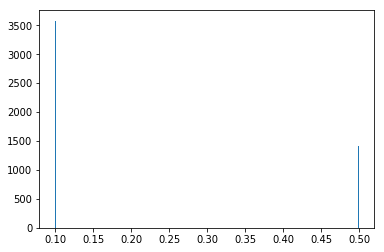

In [100]:
plt.hist(pd.DataFrame(predictions).sample().values.reshape([-1]), bins=200)
plt.show()